1. Import libraries

In [7]:
# Paths and basic setup
import os, json, time, math
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

data_dir = Path('Medicinal_plant_dataset')
num_workers = 2
batch_size = 16
seed = 42
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
print('Classes:', classes)

Device: cpu
Classes: ['Aloevera', 'Amla', 'Bamboo', 'Henna', 'Jasmine', 'Lemon', 'Mango', 'Neem', 'Pappaya', 'Tulasi']


2. Data loaders (train/val split)

In [8]:
# Train/val split using ImageFolder + random split
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_ds = datasets.ImageFolder(root=data_dir, transform=train_transforms)
class_to_idx = full_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
n_total = len(full_ds)
val_size = max(1, int(0.2 * n_total))
train_size = n_total - val_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])
val_ds.dataset.transform = val_transforms  # use val transforms for val split

print(f"Total images: {n_total}, Train: {len(train_ds)}, Val: {len(val_ds)}")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Total images: 1460, Train: 1168, Val: 292


3.  Model & optimizer

In [9]:
# Model: ResNet50 fine-tuning (last layer)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False  # freeze backbone

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(classes))  # new head
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

def accuracy(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

4. Training loop

In [10]:
epochs = 5
best_val_acc = 0.0
save_path = Path('resnet50_medicinal.pth')

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(epochs):
    # Train
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_acc += accuracy(outputs.detach(), labels) * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # Validate
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_acc += accuracy(outputs, labels) * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # Track history
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(),
                    'class_to_idx': class_to_idx}, save_path)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.4f}")

print('Best val acc:', best_val_acc)

Epoch 1/5 | Train loss 1.7293 acc 0.5788 | Val loss 1.1688 acc 0.8767
Epoch 2/5 | Train loss 0.9717 acc 0.8673 | Val loss 0.7504 acc 0.8836
Epoch 3/5 | Train loss 0.6711 acc 0.9298 | Val loss 0.5574 acc 0.9247
Epoch 4/5 | Train loss 0.5298 acc 0.9315 | Val loss 0.4881 acc 0.9247
Epoch 5/5 | Train loss 0.4084 acc 0.9640 | Val loss 0.3989 acc 0.9281
Best val acc: 0.928082191780822


5. Training curves

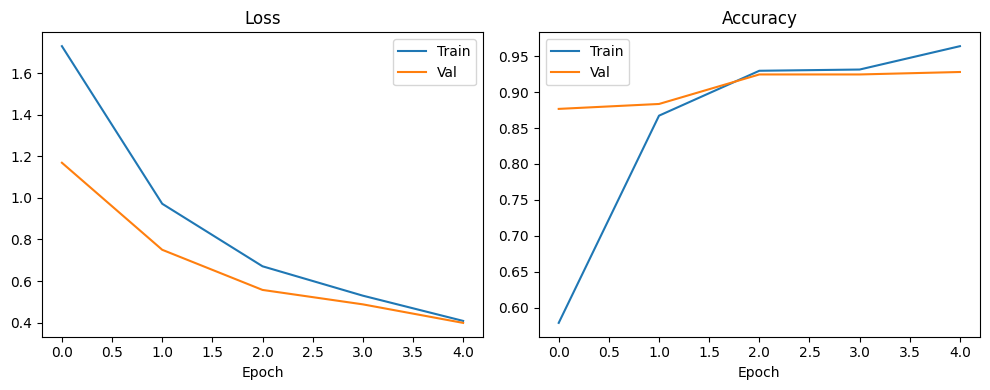

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label='Train')
plt.plot(val_loss_hist, label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label='Train')
plt.plot(val_acc_hist, label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

6. Confusion matrix on validation set

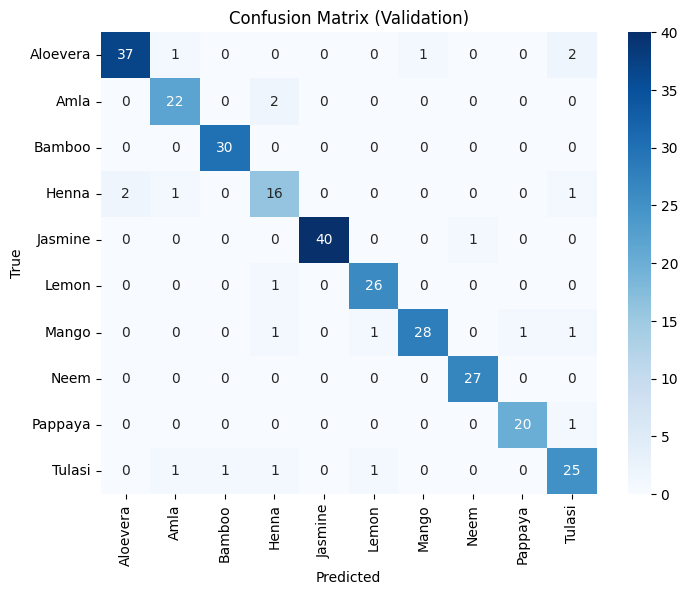

              precision    recall  f1-score   support

    Aloevera      0.949     0.902     0.925        41
        Amla      0.880     0.917     0.898        24
      Bamboo      0.968     1.000     0.984        30
       Henna      0.762     0.800     0.780        20
     Jasmine      1.000     0.976     0.988        41
       Lemon      0.929     0.963     0.945        27
       Mango      0.966     0.875     0.918        32
        Neem      0.964     1.000     0.982        27
     Pappaya      0.952     0.952     0.952        21
      Tulasi      0.833     0.862     0.847        29

    accuracy                          0.928       292
   macro avg      0.920     0.925     0.922       292
weighted avg      0.930     0.928     0.928       292



In [12]:
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation)')
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes, digits=3))

7. Evaluation on val set

In [13]:
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation accuracy: {correct / total:.4f}")

Validation accuracy: 0.9281
